**Background**  
Using devices such as Jawbone Up, Nike FuelBand, and Fitbit it is now possible to  
collect a large amount of data about personal activity relatively inexpensively. These  
type of devices are part of the quantified self movement - a group of enthusiasts who  
take measurements about themselves regularly to improve their health, to find patterns  
in their behavior, or because they are tech geeks. One thing that people regularly do is  
quantify how much of a particular activity they do, but they rarely quantify how well they  
do it. In this project, your goal will be to use data from accelerometers on the belt,  
forearm, arm, and dumbell of 6 participants. They were asked to perform barbell lifts  
correctly and incorrectly in 5 different ways. More information is available from the  
website here: http://groupware.les.inf.puc-rio.br/har (see the section on the Weight  
Lifting Exercise Dataset). 

**Data**  
The training data for this project are available here: https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv  
The test data are available here: https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv  
The data for this project come from this source:  http://groupware.les.inf.puc-rio.br/har.

#### Prepare the datasets
Read the training data into a data table.

In [2]:
require(data.table)
#setInternet2(TRUE)
url <- "https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv"
train <- fread(url)

Loading required package: data.table


Read the testing data into a data table.

In [3]:
url <- "https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv"
test <- fread(url)

Which variables in the test dataset have zero `NA`s?  
Belt, arm, dumbbell, and forearm variables that do not have any missing values in the test dataset will be **predictor candidates**.

In [4]:
isAnyMissing <- sapply(test, function (x) any(is.na(x) | x == ""))
isPredictor <- !isAnyMissing & grepl("belt|[^(fore)]arm|dumbbell|forearm", names(isAnyMissing))
predCandidates <- names(isAnyMissing)[isPredictor]
predCandidates

[1] "roll_belt"            "pitch_belt"           "yaw_belt"            
 [4] "total_accel_belt"     "gyros_belt_x"         "gyros_belt_y"        
 [7] "gyros_belt_z"         "accel_belt_x"         "accel_belt_y"        
[10] "accel_belt_z"         "magnet_belt_x"        "magnet_belt_y"       
[13] "magnet_belt_z"        "roll_arm"             "pitch_arm"           
[16] "yaw_arm"              "total_accel_arm"      "gyros_arm_x"         
[19] "gyros_arm_y"          "gyros_arm_z"          "accel_arm_x"         
[22] "accel_arm_y"          "accel_arm_z"          "magnet_arm_x"        
[25] "magnet_arm_y"         "magnet_arm_z"         "roll_dumbbell"       
[28] "pitch_dumbbell"       "yaw_dumbbell"         "total_accel_dumbbell"
[31] "gyros_dumbbell_x"     "gyros_dumbbell_y"     "gyros_dumbbell_z"    
[34] "accel_dumbbell_x"     "accel_dumbbell_y"     "accel_dumbbell_z"    
[37] "magnet_dumbbell_x"    "magnet_dumbbell_y"    "magnet_dumbbell_z"   
[40] "roll_forearm"         "pitch_forearm"        "yaw_forearm"         
[43] "total_accel_forearm"  "gyros_forearm_x"      "gyros_forearm_y"     
[46] "gyros_forearm_z"      "accel_forearm_x"      "accel_forearm_y"     
[49] "accel_forearm_z"      "magnet_forearm_x"     "magnet_forearm_y"    
[52] "magnet_forearm_z"

Subset the primary dataset to include only the **predictor candidates** and the outcome variable, `classe`.

In [5]:
varToInclude <- c("classe", predCandidates)
train <- train[, varToInclude, with=FALSE]
dim(train)
names(train)

[1] 19622    53

[1] "classe"               "roll_belt"            "pitch_belt"          
 [4] "yaw_belt"             "total_accel_belt"     "gyros_belt_x"        
 [7] "gyros_belt_y"         "gyros_belt_z"         "accel_belt_x"        
[10] "accel_belt_y"         "accel_belt_z"         "magnet_belt_x"       
[13] "magnet_belt_y"        "magnet_belt_z"        "roll_arm"            
[16] "pitch_arm"            "yaw_arm"              "total_accel_arm"     
[19] "gyros_arm_x"          "gyros_arm_y"          "gyros_arm_z"         
[22] "accel_arm_x"          "accel_arm_y"          "accel_arm_z"         
[25] "magnet_arm_x"         "magnet_arm_y"         "magnet_arm_z"        
[28] "roll_dumbbell"        "pitch_dumbbell"       "yaw_dumbbell"        
[31] "total_accel_dumbbell" "gyros_dumbbell_x"     "gyros_dumbbell_y"    
[34] "gyros_dumbbell_z"     "accel_dumbbell_x"     "accel_dumbbell_y"    
[37] "accel_dumbbell_z"     "magnet_dumbbell_x"    "magnet_dumbbell_y"   
[40] "magnet_dumbbell_z"    "roll_forearm"         "pitch_forearm"       
[43] "yaw_forearm"          "total_accel_forearm"  "gyros_forearm_x"     
[46] "gyros_forearm_y"      "gyros_forearm_z"      "accel_forearm_x"     
[49] "accel_forearm_y"      "accel_forearm_z"      "magnet_forearm_x"    
[52] "magnet_forearm_y"     "magnet_forearm_z"

Make `classe` into a factor.

In [6]:
train <- train[, classe := factor(train[, classe])]
train[, .N, classe]

classe,N
A,5580
B,3797
C,3422
D,3216
E,3607


Split the dataset into a 60% training and 40% probing dataset.

In [7]:
require(caret)
seed <- as.numeric(as.Date("2014-10-26"))
set.seed(seed)
inTrain <- createDataPartition(train$classe, p=0.6)
DTrain <- train[inTrain[[1]]]
DProbe <- train[-inTrain[[1]]]

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


Preprocess the prediction variables by centering and scaling.

In [8]:
X <- DTrain[, predCandidates, with=FALSE]
preProc <- preProcess(X)
preProc
XCS <- predict(preProc, X)
DTrainCS <- data.table(data.frame(classe = DTrain[, classe], XCS))

Created from 11776 samples and 52 variables

Pre-processing:
  - centered (52)
  - ignored (0)
  - scaled (52)


Apply the centering and scaling to the probing dataset.

In [9]:
X <- DProbe[, predCandidates, with=FALSE]
XCS <- predict(preProc, X)
DProbeCS <- data.table(data.frame(classe = DProbe[, classe], XCS))

Check for near zero variance.

In [10]:
nzv <- nearZeroVar(DTrainCS, saveMetrics=TRUE)
if (any(nzv$nzv)) nzv else message("No variables with near zero variance")

No variables with near zero variance


Examine groups of prediction variables.

Loading required package: reshape2

Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt



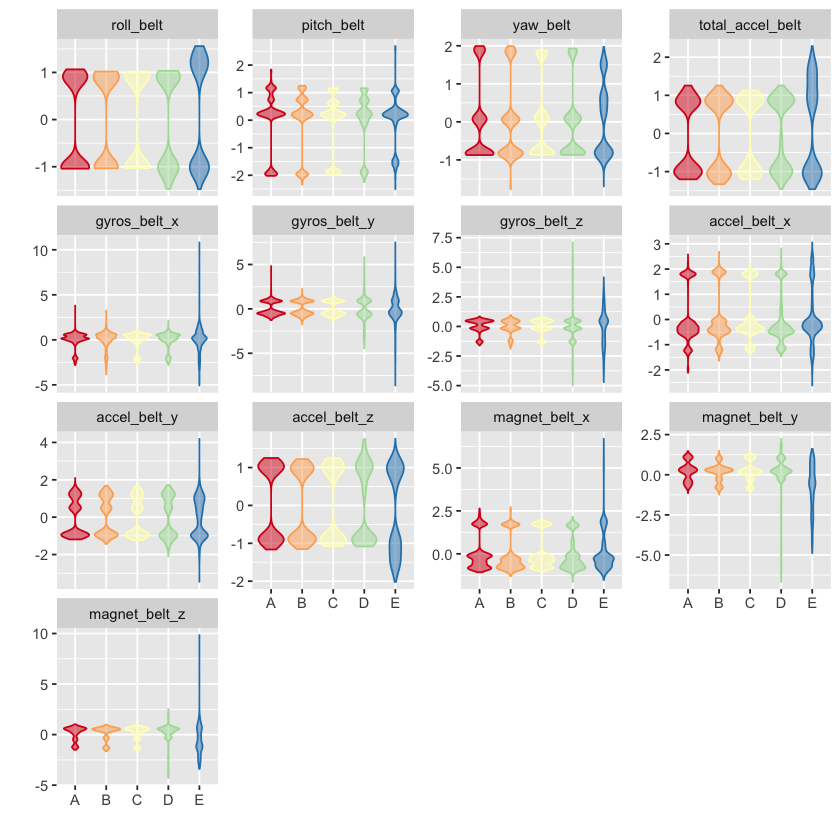

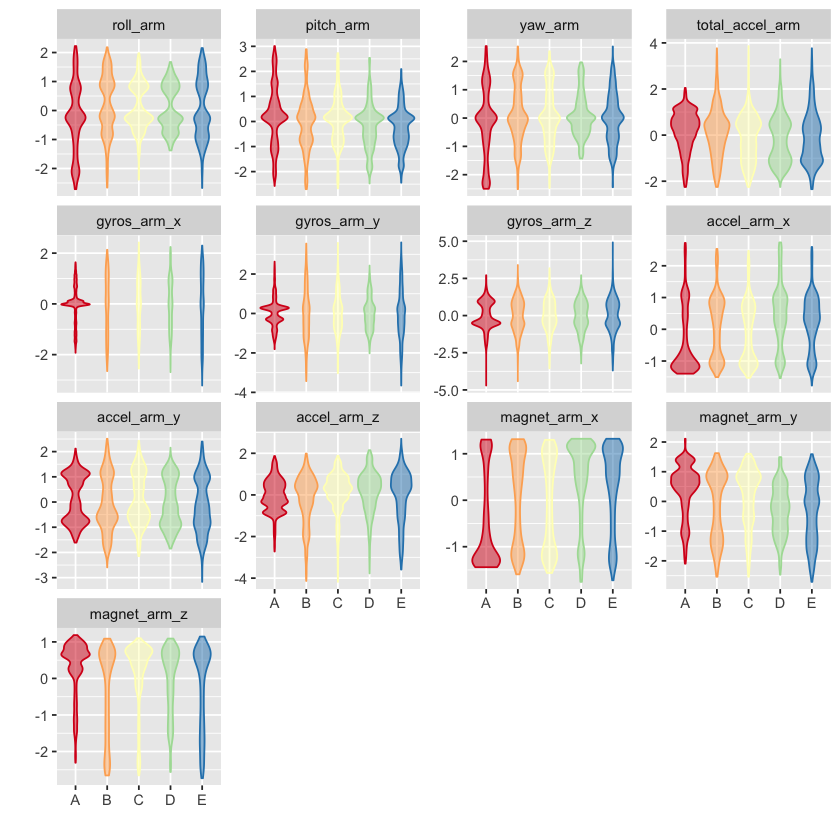

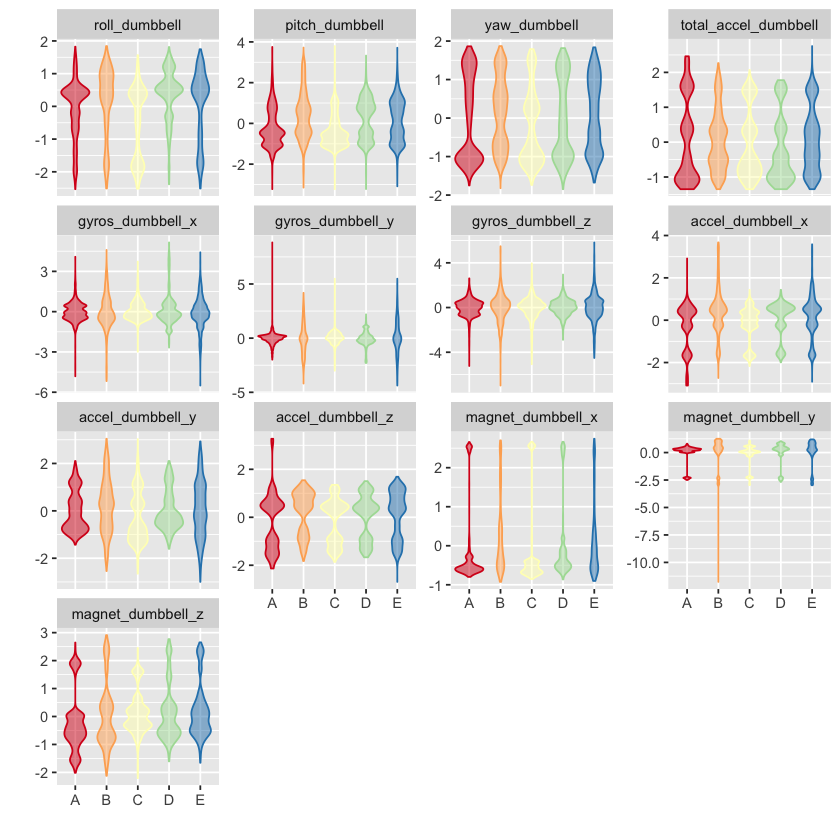

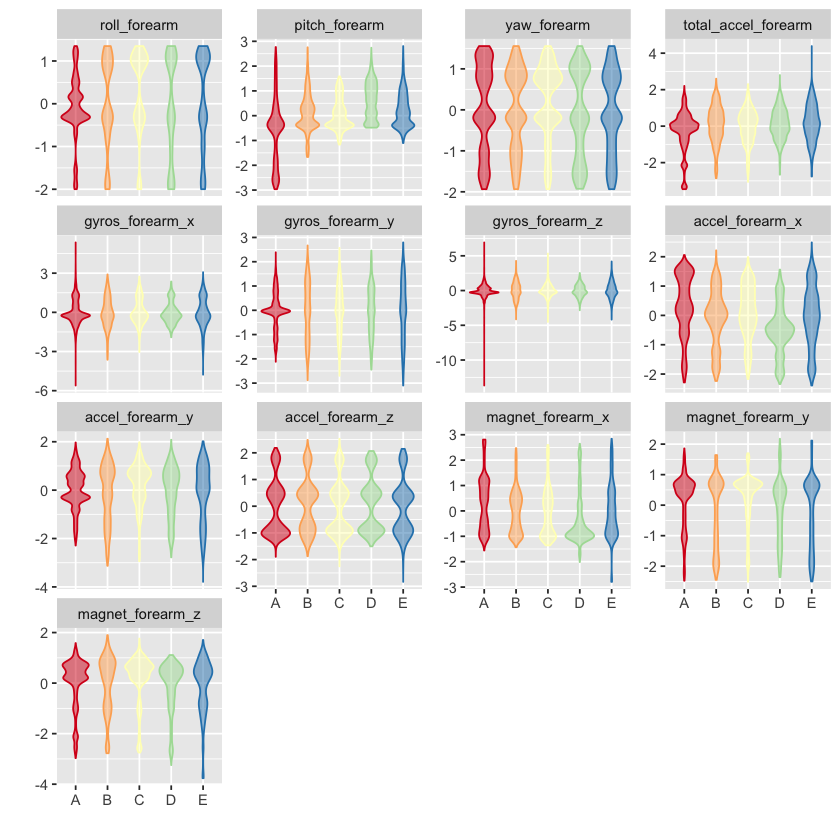

In [11]:
histGroup <- function (data, regex) {
  col <- grep(regex, names(data))
  col <- c(col, which(names(data) == "classe"))
  require(reshape2)
  n <- nrow(data)
  DMelted <- melt(data[, col, with=FALSE][, rownum := seq(1, n)], id.vars=c("rownum", "classe"))
  require(ggplot2)
  ggplot(DMelted, aes(x=classe, y=value)) +
    geom_violin(aes(color=classe, fill=classe), alpha=1/2) +
#     geom_jitter(aes(color=classe, fill=classe), alpha=1/10) +
#     geom_smooth(aes(group=1), method="gam", color="black", alpha=1/2, size=2) +
    facet_wrap(~ variable, scale="free_y") +
    scale_color_brewer(palette="Spectral") +
    scale_fill_brewer(palette="Spectral") +
    labs(x="", y="") +
    theme(legend.position="none")
}
histGroup(DTrainCS, "belt")
histGroup(DTrainCS, "[^(fore)]arm")
histGroup(DTrainCS, "dumbbell")
histGroup(DTrainCS, "forearm")

#### Train a prediction model

Using random forest, the out of sample error should be small.
The error will be estimated using the 40% probing sample.
I would be quite happy with an error estimate of 3% or less.

Set up the parallel clusters.


In [14]:
require(parallel)
require(doParallel)
library(doParallel)
cl <- makeCluster(detectCores() - 1)
registerDoParallel(cl)

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators


Set the control parameters.

In [15]:
ctrl <- trainControl(classProbs=TRUE,
                     savePredictions=TRUE,
                     allowParallel=TRUE)

Fit model over the tuning parameters.

In [16]:
method <- "rf"
system.time(trainingModel <- train(classe ~ ., data=DTrainCS, method=method))

    user   system  elapsed 
  51.672    3.762 2850.804 

Stop the clusters.

In [17]:
stopCluster(cl)

#### Evaluate the model on the training dataset

In [18]:
trainingModel
hat <- predict(trainingModel, DTrainCS)
confusionMatrix(hat, DTrain[, classe])

Random Forest 

11776 samples
   52 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 11776, 11776, 11776, 11776, 11776, 11776, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9855896  0.9817724
  27    0.9873282  0.9839718
  52    0.9771134  0.9710496

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 27.

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 3348    0    0    0    0
         B    0 2279    0    0    0
         C    0    0 2054    0    0
         D    0    0    0 1930    0
         E    0    0    0    0 2165

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9997, 1)
    No Information Rate : 0.2843     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Prevalence             0.2843   0.1935   0.1744   0.16

#### Evaluate the model on the probing dataset

In [19]:
hat <- predict(trainingModel, DProbeCS)
confusionMatrix(hat, DProbeCS[, classe])

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 2229   16    0    0    0
         B    2 1498    7    1    2
         C    0    4 1352   18    7
         D    0    0    9 1265    8
         E    1    0    0    2 1425

Overall Statistics
                                          
               Accuracy : 0.9902          
                 95% CI : (0.9877, 0.9922)
    No Information Rate : 0.2845          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9876          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9987   0.9868   0.9883   0.9837   0.9882
Specificity            0.9971   0.9981   0.9955   0.9974   0.9995
Pos Pred Value         0.9929   0.9921   0.9790   0.9867   0.9979
Neg Pred Value         0.9995   0.9968   0.9975   0.9968   0.9974
Prevalence    

#### Display the final model

In [20]:
varImp(trainingModel)
trainingModel$finalModel

rf variable importance

  only 20 most important variables shown (out of 52)

                     Overall
roll_belt            100.000
pitch_forearm         60.142
yaw_belt              53.838
pitch_belt            46.489
roll_forearm          45.165
magnet_dumbbell_y     43.873
magnet_dumbbell_z     42.966
accel_dumbbell_y      21.103
magnet_dumbbell_x     17.692
roll_dumbbell         17.641
accel_forearm_x       17.143
magnet_forearm_z      14.021
total_accel_dumbbell  13.993
accel_dumbbell_z      13.960
magnet_belt_y         13.765
magnet_belt_z         13.345
accel_belt_z          13.344
yaw_arm               11.625
gyros_belt_z          11.092
magnet_belt_x          9.877


Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 27

        OOB estimate of  error rate: 0.86%
Confusion matrix:
     A    B    C    D    E class.error
A 3341    5    2    0    0 0.002090800
B   17 2253    8    1    0 0.011408513
C    0   13 2033    8    0 0.010223953
D    1    1   30 1895    3 0.018134715
E    0    2    2    8 2153 0.005542725

**The estimated error rate is less than 1%.**

Save training model object for later.


In [21]:
save(trainingModel, file="trainingModel.RData")

#### Predict on the test data
Load the training model.

In [22]:
load(file="trainingModel.RData", verbose=TRUE)

Loading objects:
  trainingModel


Get predictions and evaluate.

In [27]:
DTestCS <- predict(preProc, test[, predCandidates, with=FALSE])
hat <- predict(trainingModel, DTestCS)
DTest <- cbind(hat , test)


#### Submission to Coursera

In [32]:
pml_write_files = function(x){
  n = length(x)
  path <- "./answers"
  for(i in 1:n){
    filename = paste0("problem_id_",i,".txt")
    write.table(x[i],file=file.path(path, filename),quote=FALSE,row.names=FALSE,col.names=FALSE)
  }
}
pml_write_files(hat)